In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, training will default to CPU.")

In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import os
#Check number of images in each folder
path = "/content/drive/MyDrive/KaggleData/Image_Dataset/"
dir_list = [os.path.join(path,i) for i in os.listdir(path) if os.path.isdir(os.path.join(path,i))]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict

{'Benign': 2480, 'Malignant': 5429}

In [ ]:
#Checking the len
len(os.listdir("/content/drive/MyDrive/KaggleData/Image_Dataset/"))

2

In [ ]:
#Function to read the dataset from a specified directory
def import_images(folder,target):
    images = []
    for item in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,item), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append([img,target])
    return images

In [ ]:
#Importing the dataset from the specified directory using the created function and assign them with labels
#Where 0 is for Benign, 1 is malignant and 1 is for Malignant
benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Benign",0)
malignant = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Malignant",1)

In [ ]:
full_data = benign + malignant  # Create a new list containing elements of both

In [ ]:
# # Save the Dataset with Pickle

import pickle

# Specify the filename you want to save the dataset as
dataset_filename = '/content/drive/MyDrive/KaggleData/full_data.pkl'

# Open a file in binary-write mode and dump the full_data list into it
with open(dataset_filename, 'wb') as dataset_file:
    pickle.dump(full_data, dataset_file)

print(f"Dataset successfully saved to {dataset_filename}")


Dataset successfully saved to /content/drive/MyDrive/KaggleData/full_data.pkl


In [ ]:
# Loading the Dataset Back
import pickle
# Open the file in binary-read mode and load the data
# Specify the filename you want to save the dataset as
dataset_filename = '/content/drive/MyDrive/KaggleData/full_data.pkl'


with open(dataset_filename, 'rb') as dataset_file:
    loaded_data = pickle.load(dataset_file)

print("Dataset successfully loaded.")
# print(f"Total number of samples in the dataset: {len(loaded_data)}")
# # Optionally, verify by inspecting the first few samples
# print(loaded_data[:5])
# #

Dataset successfully loaded.


In [ ]:
benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Benign", 0)  # Call your function

# # Check the type of the entire returned dataset
print(type(benign))

# # Check the type of the first element within the dataset
if benign:  # Check if the list is not empty
    print(type(benign[0]))

    benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Malignant", 1)  # Call your function

# # Check the type of the entire returned dataset
print(type(malignant))

# # Check the type of the first element within the dataset
if benign:  # Check if the list is not empty
    print(type(malignant[1]))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


Spliting Data:
Stratification: This process ensures that each split maintains a label
distribution similar to the original dataset, which is particularly important for imbalanced datasets.
Second Split Adjustment: The test size for the second split is adjusted to account for the fact that train_test_split was already applied once. If you want to maintain, for example, an 80/10/10 split (train/validation/test), after removing 10% for testing, 10% of the remaining 90% should be allocated for validation. This is achieved by setting test_size=(0.1/0.9) in the second train_test_split call.
By following this corrected approach, you ensure that both your validation and test sets are representative of the overall dataset, supporting more reliable evaluation and tuning of your model.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'full_data' is a list of tuples (image, label)
full_images = np.array([item[0] for item in full_data])  # Extract images
full_labels = np.array([item[1] for item in full_data])  # Extract labels for stratification

# Perform the dataset splitting into training and test set (with stratification)
train_images, test_images, train_labels, test_labels = train_test_split(
    full_images, full_labels, test_size=0.1, random_state=30, stratify=full_labels
)

# Extracting validation dataset from the training data (with correct stratification)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=(0.1/0.9), random_state=30, stratify=train_labels
)




 Normalize and Enhance Histological Images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Function to apply Z-score normalization per image
def z_score_normalization(image):
    return (image - np.mean(image)) / np.std(image)

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if image.ndim == 3 and image.shape[2] == 3:  # Color image
        for i in range(3):  # Apply CLAHE to each channel
            image[:,:,i] = clahe.apply((image[:,:,i] * 255).astype(np.uint8))
    else:  # Grayscale image
        image = clahe.apply((image * 255).astype(np.uint8))
    return image / 255.0  # Normalize back to range [0, 1]


# Normalize and augment training, validation, and test datasets
def preprocess_datasets(train_images, val_images, test_images, visualize=False):
    preprocessed_train = np.zeros_like(train_images, dtype=np.float32)
    preprocessed_val = np.zeros_like(val_images, dtype=np.float32)
    preprocessed_test = np.zeros_like(test_images, dtype=np.float32)

    # Function to process each image set
    def process_images(images):
        preprocessed = np.zeros_like(images, dtype=np.float32)
        for i, img in enumerate(images):
            normalized_img = z_score_normalization(img)
            clahe_img = apply_clahe(normalized_img)
            preprocessed[i] = clahe_img
            if visualize and i < 4:  # Visualize the first 4 images only for checking
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(normalized_img)
                plt.title(f'Normalized Image {i}')
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(clahe_img)
                plt.title(f'CLAHE Image {i}')
                plt.axis('off')
                plt.show()
        return preprocessed

    # Process each image set
    preprocessed_train = process_images(train_images)
    preprocessed_val = process_images(val_images)
    preprocessed_test = process_images(test_images)

    return preprocessed_train, preprocessed_val, preprocessed_test

# Apply the preprocessing functions and optionally visualize the first few transformations
train_images_preprocessed, val_images_preprocessed, test_images_preprocessed = preprocess_datasets(
    train_images, val_images, test_images, visualize=True
)



# Visual evaluation of transformations on a subset of images
# def visualize_transformations(original_images, transformed_images, n_images=5):
#     indices = np.random.choice(range(len(original_images)), size=n_images, replace=False)

#     plt.figure(figsize=(10, 2 * n_images))
#     for i, idx in enumerate(indices):
#         plt.subplot(n_images, 2, 2*i + 1)
#         plt.imshow(original_images[idx])
#         plt.title("Original")
#         plt.axis('off')

#         plt.subplot(n_images, 2, 2*i + 2)
#         plt.imshow(transformed_images[idx])
#         plt.title("Transformed")
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Visualize transformations
# visualize_transformations(train_images, train_images_preprocessed)
def visualize_transformations(original_images, preprocessed_images, n_images=4):
    indices = np.random.choice(range(len(original_images)), size=n_images, replace=False)

    fig, axs = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))  # Adjust the size as needed

    for i, idx in enumerate(indices):
        # Original images on the left column
        axs[i, 0].imshow(original_images[idx])
        axs[i, 0].set_title(f"Original Image {idx}")
        axs[i, 0].axis('off')

        # Transformed (preprocessed) images on the right column
        axs[i, 1].imshow(preprocessed_images[idx])
        axs[i, 1].set_title(f"Transformed Image {idx}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with your datasets
visualize_transformations(train_images, train_images_preprocessed)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define how many images to visualize
num_images_to_visualize = 4

# Function to apply Z-score normalization per image
def z_score_normalization(image):
    normalized_img = (image - np.mean(image)) / np.std(image)
    # Clip values to ensure they are between 0 and 1
    normalized_img = np.clip(normalized_img, 0, 1)
    return normalized_img

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if image.ndim == 3:  # Check for color image with three channels
        # Convert to uint8 before applying CLAHE
        image_uint8 = (image * 255).astype(np.uint8)
        # Apply CLAHE to each channel
        clahe_img = np.empty_like(image_uint8)
        for i in range(3):
            clahe_img[:, :, i] = clahe.apply(image_uint8[:, :, i])
        # Convert back to float32 and scale to 0-1 range
        clahe_img = clahe_img.astype(np.float32) / 255.0
        return clahe_img
    else:  # Grayscale image
        return clahe.apply(image)

# Function to preprocess and visualize datasets
def preprocess_datasets(train_images, visualize=False):
    preprocessed_train = np.zeros_like(train_images, dtype=np.float32)

    for i, img in enumerate(train_images):
        if i >= num_images_to_visualize and visualize:
            break  # Stop visualizing after a certain number of images

        # Apply Z-score normalization and CLAHE
        normalized_img = z_score_normalization(img)
        clahe_img = apply_clahe(normalized_img)

        # Store the preprocessed image
        preprocessed_train[i] = clahe_img

        # Optionally visualize the transformations
        if visualize:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(normalized_img)
            plt.title('Z-score Normalized')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(clahe_img)
            plt.title('CLAHE Image')
            plt.axis('off')

            plt.show()

    return preprocessed_train

# Assuming train_images is a numpy array of your training images
preprocessed_train_images = preprocess_datasets(train_images[:num_images_to_visualize], visualize=True)



In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to apply Z-score normalization per image
def z_score_normalization(image):
    image_normalized = (image - np.mean(image)) / np.std(image)
    # Rescale the normalized image to the range [0, 1]
    min_val = image_normalized.min()
    max_val = image_normalized.max()
    image_rescaled = (image_normalized - min_val) / (max_val - min_val)
    return image_rescaled

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if image.ndim == 3:  # Check for color image with three channels
        # Convert image to uint8 type with range [0, 255] for CLAHE
        image_uint8 = (image * 255).astype(np.uint8)
        clahe_img = np.empty_like(image_uint8)
        for i in range(3):  # Apply CLAHE to each channel
            clahe_img[:, :, i] = clahe.apply(image_uint8[:, :, i])
        # Convert back to float32 type with range [0, 1]
        clahe_img = clahe_img.astype(np.float32) / 255
        return clahe_img
    else:  # Grayscale image
        image_uint8 = (image * 255).astype(np.uint8)
        clahe_img = clahe.apply(image_uint8)
        # Convert back to float32 type with range [0, 1]
        return (clahe_img.astype(np.float32) / 255)

# Normalize and augment training, validation, and test datasets
def preprocess_datasets(train_images, val_images, test_images):
    preprocessed_train = np.zeros_like(train_images, dtype=np.float32)
    for i, img in enumerate(train_images):
        normalized_img = z_score_normalization(img)
        clahe_img = apply_clahe(normalized_img)
        preprocessed_train[i] = clahe_img
        # If you want to visualize all the images, remove the following if condition
        if i < 4:  # Only visualize the first 4 images
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(normalized_img)
            plt.title('Normalized Image')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(clahe_img)
            plt.title('CLAHE Image')
            plt.axis('off')

            plt.show()

    # Apply the same process to val_images and test_images if necessary

    return preprocessed_train

# Assuming train_images, val_images, and test_images are your datasets
train_images_preprocessed = preprocess_datasets(train_images)


**Normalisation/Using Median Filtering**

In [ ]:
import cv2
import numpy as np
from skimage import exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

# Integrate Median filtering into the preprocessing pipeline
def preprocess_images_with_median(images):
    preprocessed_images = np.zeros_like(images)
    for i in range(len(images)):
        # Apply median filter
        filtered = apply_median_filter(images[i], kernel_size=3)
        # Normalize and enhance
        normalized = (filtered - np.mean(filtered)) / np.std(filtered)
        enhanced = exposure.equalize_adapthist(normalized)  # CLAHE
        preprocessed_images[i] = enhanced
    return preprocessed_images

# Assuming your datasets are loaded into training_dataset, val_dataset, test_dataset
training_dataset_preprocessed = preprocess_images_with_median(training_dataset)
val_dataset_preprocessed = preprocess_images_with_median(val_dataset)
test_dataset_preprocessed = preprocess_images_with_median(test_dataset)


**Normalisation/Using Bilateral Filtering**

In [ ]:
def apply_bilateral_filter(image, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

# Integrate Bilateral filtering into the preprocessing pipeline
def preprocess_images_with_bilateral(images):
    preprocessed_images = np.zeros_like(images)
    for i in range(len(images)):
        # Apply bilateral filter
        filtered = apply_bilateral_filter(images[i])
        # Normalize and enhance
        normalized = (filtered - np.mean(filtered)) / np.std(filtered)
        enhanced = exposure.equalize_adapthist(normalized)  # CLAHE
        preprocessed_images[i] = enhanced
    return preprocessed_images

training_dataset_preprocessed = preprocess_images_with_bilateral(training_dataset)
val_dataset_preprocessed = preprocess_images_with_bilateral(val_dataset)
test_dataset_preprocessed = preprocess_images_with_bilateral(test_dataset)


In [ ]:
IMG_SIZE = 224  # Example image size

# Load the dataset
with open('/content/drive/MyDrive/KaggleData/full_data.pkl', 'rb') as file:
    full_data = pickle.load(file)


# Prepare your data and labels
full_images = np.array([item[0] for item in full_data])  # Image data
full_labels = np.array([item[1] for item in full_data])  # Labels

# Reshape image data for oversampling
full_images_reshaped = full_images.reshape(-1, IMG_SIZE * IMG_SIZE * 3)

# Initial train/test split with stratification
training_data_reshaped, test_data_reshaped, training_labels, test_labels = train_test_split(
    full_images_reshaped, full_labels, test_size=0.1, random_state=30, stratify=full_labels)

# Apply RandomOverSampler on the reshaped training data
ros = RandomOverSampler(random_state=42)
training_data_resampled, training_labels_resampled = ros.fit_resample(training_data_reshaped, training_labels)

# Reshape the data back to its original shape after oversampling
training_dataset = training_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Extracting validation dataset from the training data (with stratification)
training_dataset, val_dataset, training_labels, val_labels = train_test_split(
    training_dataset, training_labels_resampled, test_size=0.1, random_state=30, stratify=training_labels_resampled)

# Reshape test data back to its original shape
test_dataset = test_data_reshaped.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 8794
Validation dataset size: 978
Test dataset size: 791


In [ ]:
# # #Performing the dataset splitting into training and test set
# training_data, test_dataset = train_test_split(full_data, test_size = 0.1, random_state = 30)

In [ ]:
# # #Extracting validation dataset from the training data
# training_dataset, val_dataset = train_test_split(training_data, test_size = 0.1, random_state = 30)

In [ ]:
# """Function to separate the dataset into images and label puting the images in array called feature_map and labels into
# array called label"""

# def split_data(main_data):
#     feature_matrix = []
#     label = []
#     for x,y in main_data:
#         feature_matrix.append(x)
#         label.append(y)
#     return np.array(feature_matrix), np.array(label)

In [ ]:
pip install numpy opencv-python scikit-learn imbalanced-learn


In [ ]:
# '''Pixel Value Scaling: scale the pixel values to a [0, 1] range by dividing by 255. This method is beneficial for almost all deep learning models and should be your baseline preprocessing step.'''
# # Normalize training dataset
# training_dataset = np.array(training_dataset, dtype="float32") / 255.0

# # Normalize validation dataset
# val_dataset = np.array(val_dataset, dtype="float32") / 255.0

# # Normalize test dataset
# test_dataset = np.array(test_dataset, dtype="float32") / 255.0


In [ ]:
# '''Global Intensity Normalization: A simple approach is to normalize the pixel values globally across the entire dataset to a common scale, such as [0, 1] or [-1, 1].'''
# ## Assuming images are stored in a NumPy array "images"
# images_normalized = (images - np.min(images)) / (np.max(images) - np.min(images))
# # Now, images_normalized contains values scaled to [0, 1]


In [ ]:
# '''Per-Image Intensity Normalization: Normalize each image individually to account for variations between images.
# This can be more effective when the intensity variations are significant across images.'''
# images_normalized = np.zeros_like(images)
# for i in range(len(images)):
#     images_normalized[i] = (images[i] - np.min(images[i])) / (np.max(images[i]) - np.min(images[i]))


In [ ]:
# '''Z-score Normalization (Standardization): normalize images based on the mean and standard deviation of either the entire dataset or each image individually.
# This can be particularly effective if your dataset has images with varying illumination or contrast but requires careful application to not obscure subtle diagnostic features.
# When to use: If there's significant variation in brightness and contrast across your images, and you've observed that model training is sensitive to these variations.
# '''
# # Per-image Z-score normalization
# images_standardized = np.zeros_like(images)
# for i in range(len(images)):
#     images_standardized[i] = (images[i] - np.mean(images[i])) / np.std(images[i])


Histogram Equalization. This technique can enhance the contrast in your images, making features more discernible. CLAHE (Contrast Limited Adaptive Histogram Equalization) is a variant that prevents over-amplification of noise and is often preferred for medical images.

When to use: If your dataset suffers from poor contrast and if enhancing the contrast could help in emphasizing important tissue characteristics.

In [ ]:
# import cv2
# import numpy as np

# images_equalized = np.zeros_like(images)
# for i in range(len(images)):
#     img = images[i]
#     if img.ndim == 3 and img.shape[-1] == 3:  # Check if the image is colored
#         for j in range(3):  # Apply CLAHE to each channel
#             clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#             images_equalized[i][:,:,j] = clahe.apply(img[:,:,j])
#     else:  # If the image is grayscale
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#         images_equalized[i] = clahe.apply(img)


In [ ]:
#The first label in the dataset
training_labels[0]

1

In [ ]:
#Check the data distribution among the classes
print(pd.Series(training_labels).value_counts())

1    4397
0    2009
dtype: int64


In [ ]:
#The first label in the dataset
test_labels[0]

1

In [ ]:
import pandas as pd
#Check the data distribution among the classes
print(pd.Series(test_labels).value_counts())

1    543
0    248
dtype: int64


In [ ]:
#The first label in the dataset
val_labels[0]

1

In [ ]:
import pandas as pd

# Check the data distribution among the classes for training, validation, and test sets
print("Training labels distribution:\n", pd.Series(training_labels).value_counts())
print("Validation labels distribution:\n", pd.Series(val_labels).value_counts())
print("Test labels distribution:\n", pd.Series(test_labels).value_counts())


Training labels distribution:
 1    4397
0    4397
dtype: int64
Validation labels distribution:
 0    489
1    489
dtype: int64
Test labels distribution:
 1    543
0    248
dtype: int64


# Model Training

In [ ]:
#Importing libraries needed for the modeling and training
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
#Setting the batch size for the cnn model
bs = 64

In [ ]:
#Defining Image Data Generator for image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],  # Example color space augmentation
    channel_shift_range=20  # Example for randomly shifting color channels
)


# Custom CNN Model 1

In [ ]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (224,224,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Fifth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 128)       0

In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
# checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

In [ ]:
# Assuming training_dataset and val_dataset are your prepared and possibly normalized datasets
training_images = training_dataset
val_images = val_dataset


#Fitted the model on the training and and validation dataset using the image augmentor for 100 epochs
history = cancer_model.fit(datagen.flow(training_images, training_labels, batch_size = bs),
                                     validation_data=datagen.flow(val_images, val_labels),
                                     epochs=50,
                                     callbacks=[rlrp],
                                     verbose = 1)

Epoch 1/50
138/138 [==============================] - 108s 708ms/step - loss: 0.4201 - accuracy: 0.8165 - val_loss: 0.3425 - val_accuracy: 0.8671 - lr: 8.7951e-04
Epoch 2/50
138/138 [==============================] - 97s 703ms/step - loss: 0.3486 - accuracy: 0.8648 - val_loss: 0.3423 - val_accuracy: 0.8845 - lr: 7.8431e-04
Epoch 3/50
138/138 [==============================] - 97s 704ms/step - loss: 0.3289 - accuracy: 0.8753 - val_loss: 0.3298 - val_accuracy: 0.8834 - lr: 7.0771e-04
Epoch 4/50
138/138 [==============================] - 97s 700ms/step - loss: 0.3295 - accuracy: 0.8696 - val_loss: 0.3163 - val_accuracy: 0.8804 - lr: 6.4475e-04
Epoch 5/50
138/138 [==============================] - 98s 708ms/step - loss: 0.3183 - accuracy: 0.8804 - val_loss: 0.3005 - val_accuracy: 0.8865 - lr: 5.9207e-04
Epoch 6/50
138/138 [==============================] - 96s 697ms/step - loss: 0.3031 - accuracy: 0.8861 - val_loss: 0.3038 - val_accuracy: 0.8814 - lr: 5.4735e-04
Epoch 7/50
138/138 [=======

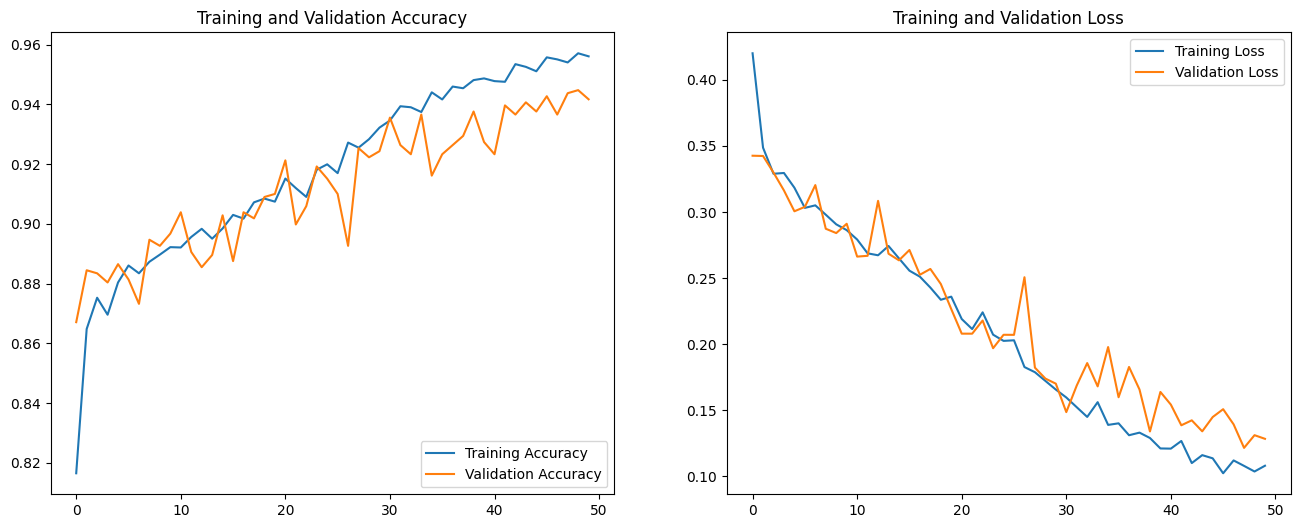

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Performance Evaluation of custom CNN model 1

In [ ]:
import numpy as np

y_pred = cancer_model.predict(test_dataset)


# y_pred = cancer_model.predict(test_images)

25/25 [==============================] - 1s 47ms/step


In [ ]:
print(y_pred)

[[9.99994874e-01]
 [9.99965549e-01]
 [9.05130148e-01]
 [9.88917470e-01]
 [2.82516261e-03]
 [2.79852282e-03]
 [9.33645606e-06]
 [9.96740997e-01]
 [9.96764660e-01]
 [5.66582620e-01]
 [9.99999523e-01]
 [9.99791920e-01]
 [9.99862671e-01]
 [1.00000000e+00]
 [9.80358124e-01]
 [9.97126997e-01]
 [1.53792918e-01]
 [1.69940218e-02]
 [4.61766958e-01]
 [1.58134654e-01]
 [9.98851299e-01]
 [9.99995708e-01]
 [2.77222916e-05]
 [9.94068027e-01]
 [3.40951234e-02]
 [9.28319618e-02]
 [9.99953270e-01]
 [3.65529908e-04]
 [2.56885979e-02]
 [9.95421588e-01]
 [1.45320697e-02]
 [9.73222673e-01]
 [9.99997377e-01]
 [9.99377191e-01]
 [1.11196243e-06]
 [3.31612408e-01]
 [9.94740069e-01]
 [9.43527102e-01]
 [9.99965906e-01]
 [9.64872003e-01]
 [9.99404907e-01]
 [9.99969959e-01]
 [9.96523261e-01]
 [7.48852789e-01]
 [9.97112274e-01]
 [6.71265787e-03]
 [3.23945045e-04]
 [4.48783487e-03]
 [1.67076495e-02]
 [9.99999404e-01]
 [9.57635716e-02]
 [9.99902010e-01]
 [7.77880028e-02]
 [7.68643677e-01]
 [1.74272736e-03]
 [9.983413

In [ ]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in y_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1
 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1
 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1
 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0
 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 

<ipython-input-55-eb069268529b>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_pred]


In [ ]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in y_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1
 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1
 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1
 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0
 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 

<ipython-input-56-eb069268529b>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_pred]


In [ ]:
#Classification report
print(classification_report(test_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.92      0.88      0.89       248
           1       0.94      0.96      0.95       543

    accuracy                           0.94       791
   macro avg       0.93      0.92      0.92       791
weighted avg       0.94      0.94      0.94       791



[[217  31]
 [ 20 523]]


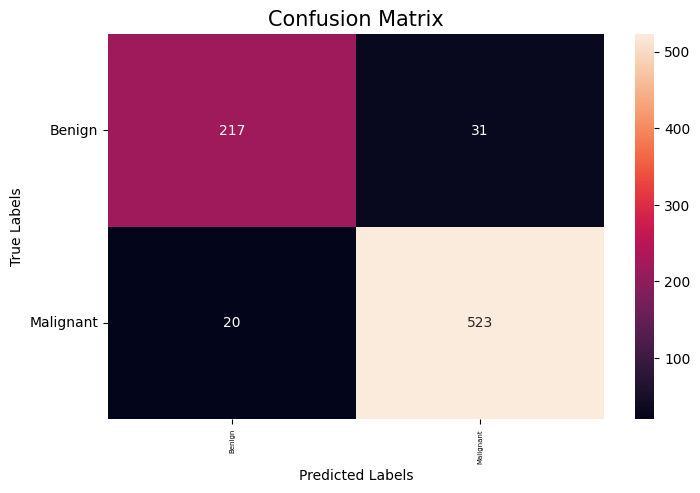

In [ ]:
#Confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)
print(cm)

import seaborn as sns

#Setting the labels
labels = ['Benign', 'Malignant']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

In [ ]:
#Accuracy
accuracy = accuracy_score(test_labels, rounded_predictions)
print('Accuracy: %f' % accuracy)

Accuracy: 0.930468


In [ ]:
#Precision
precision = precision_score(test_labels, rounded_predictions)
print('Precision: %f' % precision)

Precision: 0.935714


In [ ]:
# Recall
recall = recall_score(test_labels, rounded_predictions, pos_label=1)
print('Recall: %f' % recall)

Recall: 0.965009


In [ ]:
#Specificity
specificity = recall_score(test_labels, rounded_predictions, pos_label=0)
print('Specificity: %f' % specificity)

Specificity: 0.854839


In [ ]:
#F1-score
F1_score = f1_score(test_labels, rounded_predictions)
print('F1_score: %f' % F1_score)

F1_score: 0.950136


# ROC CURVE

In [ ]:
print("test_labels shape:", test_labels.shape)
print("y_pred shape:", y_pred.shape)

test_labels shape: (791,)
y_pred shape: (791, 1)


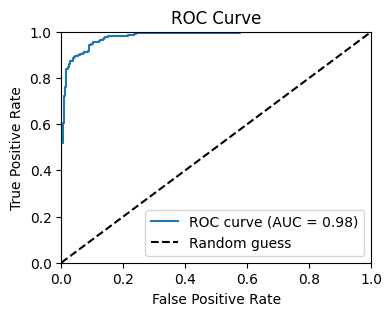

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred[:, 0])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

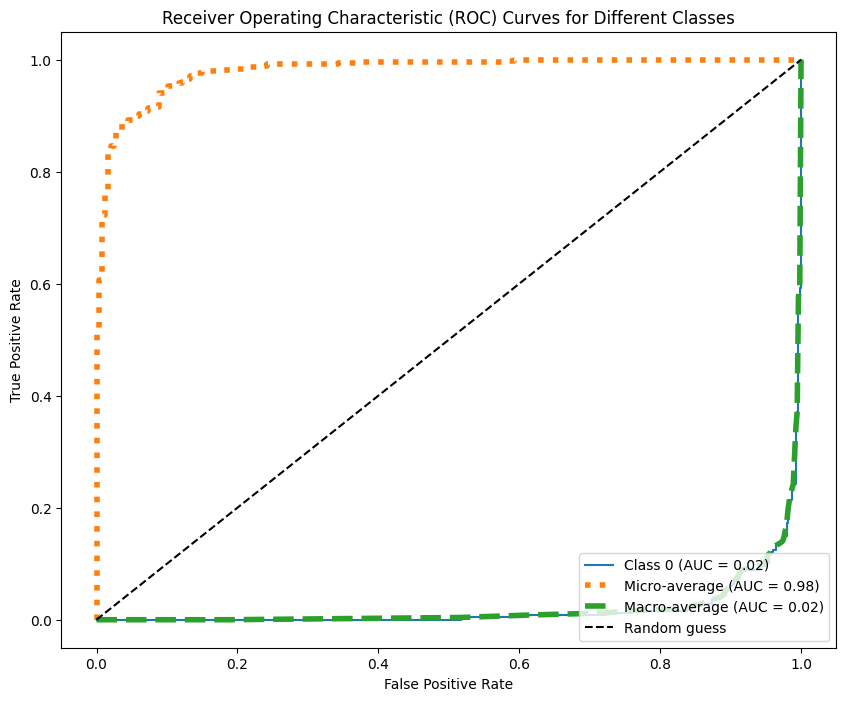

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_pred has probabilities for each class
n_classes = y_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(test_labels, y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot individual class ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle='--', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Classes')
plt.legend(loc='lower right')
plt.show()


**CNN Model 2**

In [ ]:
#Setting the batch size for the cnn model
bs = 64

In [ ]:
# Set up data generators with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [ ]:
# Define the CNN Model
cancer_model = Sequential([
    Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    Conv2D(16, 3, activation=act, padding='same'),
    Conv2D(16, 3, activation=act, padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(32, 3, activation=act, padding='same'),
    Conv2D(32, 3, activation=act, padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(64, 3, activation=act, padding='same'),
    Conv2D(64, 3, activation=act, padding='same'),
    Conv2D(64, 3, activation=act, padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.2),
    Conv2D(128, 3, activation=act, padding='same'),
    Conv2D(128, 3, activation=act, padding='same'),
    Conv2D(128, 3, activation=act, padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation=act),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation=act),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation=act),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
], name='cnn_model')





NameError: name 'Input' is not defined

In [ ]:
# Compile the model
cancer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Setup callbacks for model saving and early stopping
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)



In [ ]:
#Fitted the model on the training and and validation dataset using the image augmentor for 100 epochs
history = cancer_model.fit(datagen.flow(training_images, training_labels, batch_size = bs),
                                     validation_data=datagen.flow(val_images, val_labels),
                                     epochs=50,
                                     callbacks=[checkpoint_cb, early_stopping_cb],
                                     verbose = 1)

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
import transformers
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import TrainingArguments, Trainer
import datasets
from datasets import load_metric
from sklearn.model_selection import train_test_split

# Assuming `full_data` is your dataset loaded earlier with labels
full_images = np.array([item[0] for item in full_data])
full_labels = np.array([item[1] for item in full_data])

# Splitting dataset
train_images, test_val_images, train_labels, test_val_labels = train_test_split(full_images, full_labels, test_size=0.2, random_state=42, stratify=full_labels)
val_images, test_images, val_labels, test_labels = train_test_split(test_val_images, test_val_labels, test_size=0.5, random_state=42, stratify=test_val_labels)

# Initialize ViT feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)

# Prepare datasets
def preprocess_images(images, labels):
    """Preprocess images and labels for training with ViT."""
    encode = feature_extractor(images, return_tensors='pt', padding=True)
    labels = torch.tensor(labels)
    return encode, labels

train_encoded, train_labels = preprocess_images(train_images, train_labels)
val_encoded, val_labels = preprocess_images(val_images, val_labels)

# Define Trainer and TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    evaluate_during_training=True,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Use train_dataset directly
    eval_dataset=val_dataset,     # Use val_dataset directly
)

# Train the model
trainer.train()

In [ ]:
# DataLoader Creation


from torch.utils.data import DataLoader, Dataset
import torch

class ImageDataset(Dataset):
    def __init__(self, images, labels, feature_extractor):
        self.images = images
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Preprocess image
        image = self.feature_extractor(images=[image], return_tensors="pt").pixel_values[0]
        return image, torch.tensor(label).long()

# Create Dataset and DataLoader for training and validation sets
train_dataset = ImageDataset(train_images, train_labels, feature_extractor)
val_dataset = ImageDataset(val_images, val_labels, feature_extractor)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:
# Extracting Attention Maps

def extract_attention_maps(model, dataloader):
    model.eval()
    attention_maps = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(model.device)
            outputs = model(images, output_attentions=True)
            attentions = outputs.attentions
            # Example: Extract and average the last layer's attention maps across all heads
            last_layer_attentions = attentions[-1]  # Get the last layer
            mean_attention = last_layer_attentions.mean(dim=1)  # Average across heads
            attention_maps.append(mean_attention.cpu().numpy())
    return np.concatenate(attention_maps, axis=0)


In [ ]:
# Calculating the TAVAC Score

from scipy.stats import pearsonr

def calculate_tavac_score(train_attention_maps, val_attention_maps):
    # Assuming train_attention_maps and val_attention_maps are processed to be directly comparable
    # Calculate Pearson correlation for each pair of attention maps and average the scores
    scores = [pearsonr(train_map.flatten(), val_map.flatten())[0] for train_map, val_map in zip(train_attention_maps, val_attention_maps)]
    tavac_score = np.mean(scores)
    return tavac_score


In [ ]:
# Assuming your model is already trained
train_attention_maps = extract_attention_maps(model, train_dataloader)
val_attention_maps = extract_attention_maps(model, val_dataloader)

# Calculate TAVAC score
tavac_score = calculate_tavac_score(train_attention_maps, val_attention_maps)
print(f"TAVAC Score: {tavac_score}")
